# GARCH

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
file_path = "..\data\ALGO_daily.csv"
df = pd.read_csv(file_path)
df.rename(columns={'timestamp': 'Date'}, inplace=True)
df.set_index('Date', inplace=True)
df.head(2)

,open,high,low,close,return,RV,lnRV,lnRV_1D_ahead,lnRV_3D_ahead,lnRV_7D_ahead,lnRV_30D_ahead
Date,,,,,,,,,,,
2019-06-23,2.190,2.234,1.800,1.934,-0.125224,0.020962,-3.865058,-3.652501,-3.331801,-4.888673,-4.531543
2019-06-24,1.932,2.020,1.301,1.416,-0.311754,0.025926,-3.652501,-3.161881,-3.956779,-4.830684,-4.813612


In [4]:
# Train-Test Split (80% train, 20% test)
dfs = {}
for h in [1, 3, 7, 30]:
    
    df_h = df[['return', ''f'lnRV_{h}D_ahead']].copy()
    df_h.dropna(inplace=True)

    train_size = int(0.8 * len(df_h))
    r_train, r_test = df_h['return'][:train_size], df_h['return'][train_size:]
    lnRV_test = df_h[''f'lnRV_{h}D_ahead'][train_size:]
    dfs[h] = {'r_train': r_train, 'r_test': r_test, 'lnRV_test': lnRV_test}

    print(f"Train-Test Split for {h}D ahead:")
    print("Training Set Size:", train_size)  
    print("Test Set starts:", r_test.index[0])
    print()

Train-Test Split for 1D ahead:
Training Set Size: 1661
Test Set starts: 2024-01-09

Train-Test Split for 3D ahead:
Training Set Size: 1660
Test Set starts: 2024-01-08

Train-Test Split for 7D ahead:
Training Set Size: 1656
Test Set starts: 2024-01-04

Train-Test Split for 30D ahead:
Training Set Size: 1638
Test Set starts: 2023-12-17



### Box-Jenkins

#### ACF & PACF

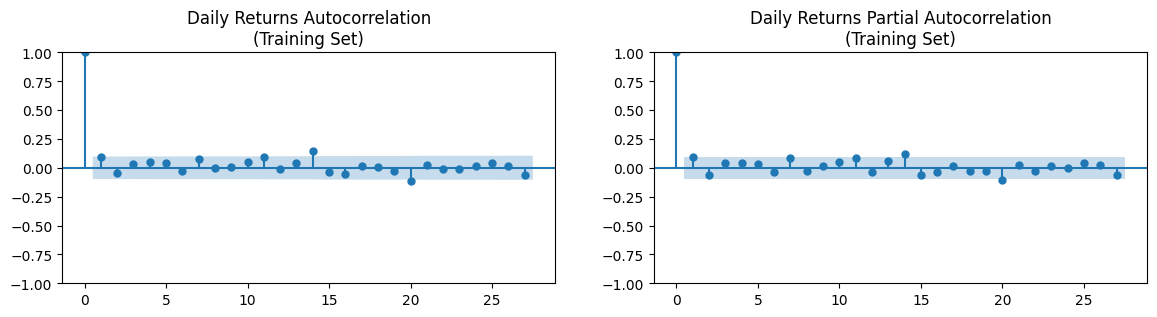

In [5]:
# ACF and PACF plots of returns
fig, ax = plt.subplots(1, 2, figsize=(14, 3))
plot_acf(dfs[30]['r_test'], title='Daily Returns Autocorrelation\n(Training Set)', ax=ax[0])
plot_pacf(dfs[30]['r_test'], title='Daily Returns Partial Autocorrelation\n(Training Set)', ax=ax[1])
plt.show()

In [6]:
def report_ic(p, o, q, h):
    model = arch_model(dfs[h]['r_train'], vol='Garch', p=p, o=o, q=q, rescale=False)
    results = model.fit(disp='off')
    aic = results.aic
    bic = results.bic
    return aic, bic

In [11]:
# save AIC and BIC values to a table
estat_1D = pd.DataFrame({
    'ARCH(1)': report_ic(1, 0, 0, 1),
    'GARCH(1)': report_ic(1, 0, 1, 1),
    'EGARCH(1)': report_ic(1, 1, 1, 1),
}, index=['AIC', 'BIC'])
print('1D:\n', estat_1D)

estat_3D = pd.DataFrame({
    'ARCH(1)': report_ic(1, 0, 0, 3),
    'GARCH(1)': report_ic(1, 0, 1, 3),
    'EGARCH(1)': report_ic(1, 1, 1, 3),
}, index=['AIC', 'BIC'])
print('3D:\n', estat_3D)

estat_7D = pd.DataFrame({
    'ARCH(1)': report_ic(1, 0, 0, 7),
    'GARCH(1)': report_ic(1, 0, 1, 7),
    'EGARCH(1)': report_ic(1, 1, 1, 7),
}, index=['AIC', 'BIC'])
print('7D:\n', estat_7D)

estat_30D = pd.DataFrame({
    'ARCH(1)': report_ic(1, 0, 0, 30),
    'GARCH(1)': report_ic(1, 0, 1, 30),
    'EGARCH(1)': report_ic(1, 1, 1, 30),
}, index=['AIC', 'BIC'])
print('30D:\n', estat_30D)

1D:
          ARCH(1)     GARCH(1)    EGARCH(1)
AIC -4517.195483 -4754.944462 -4753.254518
BIC -4500.949958 -4733.283762 -4726.178643
3D:
          ARCH(1)     GARCH(1)    EGARCH(1)
AIC -4347.132133 -4753.621098 -4751.973248
BIC -4330.888414 -4731.962806 -4724.900383
7D:
          ARCH(1)     GARCH(1)    EGARCH(1)
AIC -4335.196206 -4740.578693 -4738.909457
BIC -4318.959725 -4718.930052 -4711.848656
30D:
          ARCH(1)     GARCH(1)    EGARCH(1)
AIC -4281.099286 -4681.433768 -4684.331221
BIC -4264.895592 -4659.828843 -4657.325065


### General Wrapper Functions

In [52]:
def predict(log_returns, p, o, q, h):
    """
    Parameters:
    log_returns (array-like): Daily log return series r₁,..rₙ for the asset

    p (int): order of the GARCH term
    o (int): order of the asymmetric term
    q (int): order of the ARCH term

    h (int): forecast horizon (number of days ahead)
    
    Returns:
    forecast (float): forecasted value of σ²ₙ₊₁
    """
    # Step 1: Estimate GARCH parameters
    model = arch_model(log_returns.values, vol='Garch', p=p, o=o, q=q, rescale=False)
    results = model.fit(disp='off')
    
    # Step 2: Compute one-day-ahead forecast of σₙ₊₁
    forecast = results.forecast(horizon=h).variance.values[-1, -1]
    
    return forecast

In [53]:
def get_pred(p, o, q, h):

    pred = []
    
    r_train, r_test = dfs[h]['r_train'], dfs[h]['r_test']
    
    for i in range(len(r_test)):
        log_returns = pd.concat([r_train, r_test[:i]])
        forecast = predict(log_returns, p, o, q, h)
        pred.append(np.log(forecast))
    pred = pd.DataFrame(pred, index = r_test.index, columns=['Predicted'])
    return pred

In [54]:
def plot_pred(pred, h, model):
    actual = dfs[h]['lnRV_test']
    plt.figure(figsize=(8, 3))
    plt.plot(actual, color='black', label='Actual')
    plt.plot(pred, color='blue', label='Predicted')
    plt.xticks(actual.index[::100])
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.title(''f'{model} Predicted vs Actual log Realized Volatility')
    plt.legend()
    plt.savefig(''f'../res/{h}D/{model}_Actual_vs_Predicted.png')

### ARCH Framework

$$ r_t = \mu + \epsilon_t， \epsilon_t = z_t \sigma_t \\
\sigma_t^2 = \omega + \sum^p_{i=1}\alpha_i \epsilon_{t-1}^2 $$

where $r_t$ is the return series with its mean $\mu$, $\epsilon_t$ the error term and $\sigma_t^2$ the conditional variance. 

$z_t$ is assumed to be an I.I.D. process with $z_t \sim \mathcal{N}(0,1)$. 

To impose that the conditional variance is always nonnegative the parametric constraints are $\omega > 0$ and $\alpha_i \geq 0$. 

The ARCH model is a symmetric model, which implies that a positive shock has the same influence on the conditional variance as a negative shock of the same size.



#### ARCH(1)

##### Assume normal distribution of error

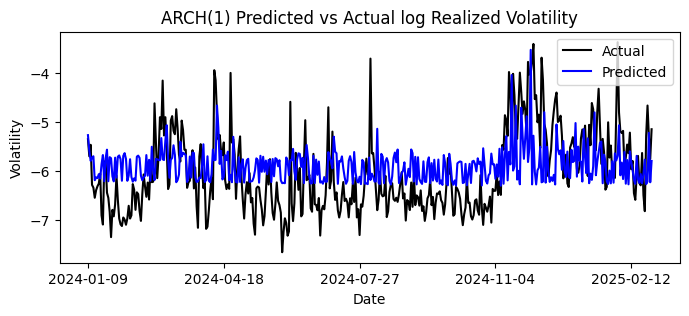

In [55]:
df_pred_1D = get_pred(1, 0, 0, 1)
df_pred_1D.to_csv('../res/1D/ARCH(1).csv', index=False)
plot_pred(df_pred_1D, 1, 'ARCH(1)')

### GARCH

An extended form of the ARCH(p) model is the generalized autoregressive conditional het
eroskedasticity (GARCH(p,q)) model by Bollerslev (1986).

$$ r_t = \mu + \epsilon_t， \epsilon_t = z_t \sigma_t \\
\sigma_t^2 = \omega + \sum^q_{i=1}\alpha_i \epsilon_{t-i}^2 + \sum^p_{j=1}\beta_j \sigma_{t-j}^2$$

The parametric restrictions for the GARCH model are: $\omega > 0$ and $\alpha_i \geq 0 $ $ \forall i$, $\beta_j \geq 0 $ $ \forall j$, to guarantee that $\sigma_t^2$ is always positive and $\alpha_i + \beta_j < 1 $ $ \forall i, j$ to guarantee a covariance stationary process. 

The GARCH model has a symmetric form similar to the ARCH model and therefore does
not allow for different responses to positive or negative shocks, which is considered as a
downside of the GARCH model.

#### GARCH(1,1)

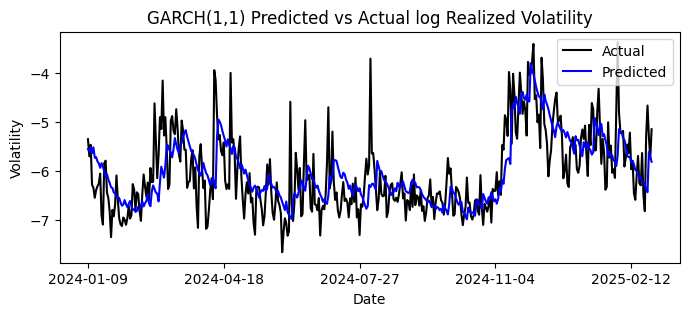

In [56]:
df_pred_1D = get_pred(1, 0, 1, 1)
df_pred_1D.to_csv('../res/1D/GARCH(1,1).csv', index=False)
plot_pred(df_pred_1D, 1, 'GARCH(1,1)')

### EGARCH


#### EGARCH(1,1,1)

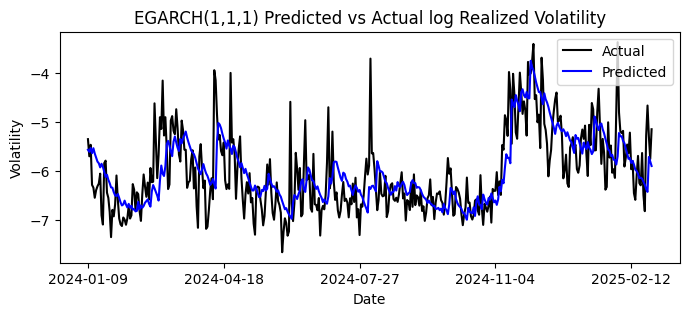

In [57]:
df_pred_1D = get_pred(1, 1, 1, 1)
df_pred_1D.to_csv('../res/1D/EGARCH(1,1,1).csv', index=False)
plot_pred(df_pred_1D, 1, 'EGARCH(1,1,1)')